# Solving Linear Systems of Equations using HHL

In this block we:

    * ... illustrate the concepts of the HHL in practice
    * ... decompose some elements on which the HHL is based upon

***

... usual declarations

In [1]:
# Import numpy & usual libraries, check the qiskit version etc.
import numpy as np

# Import basic object from the Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer,BasicAer
from qiskit import execute

# We will need these two
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

# Load account from the disk
from qiskit import IBMQ
IBMQ.load_account() 

# We will need this for plots
from qiskit.visualization import plot_histogram,plot_bloch_multivector

In [2]:
# Check the version of the qiskit you use

# Compared to previous class, I have installed the up-to-date version
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [3]:
# Ideal simulator
simulator = Aer.get_backend('qasm_simulator')

# Real-like simulator
from qiskit.providers.aer.noise import NoiseModel

# Choose a particuler quantum computer 
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')

# We derive the noise model from the chosen quantum computer
noise_model = NoiseModel.from_backend(backend)

# Further, we assume the specific qauntum computer:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# define backend (simulator)
backendSim = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024
)

# define backend (simulator with specific noise)
backendSimWithNoise = QuantumInstance(
    Aer.get_backend("qasm_simulator"), 
    coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                shots=1024
)

ibmqfactory.load_account:WARNING:2022-03-28 23:53:28,671: Credentials are already in use. The existing account in the session will be replaced.


***

Our objective is to solve system of linear equations using the HHL. 

We start with classical solution and then compare it to quantum one. 

* Our objective is to illustrate the algorithm we have described, we do not aim to get a proof of numerical speed up.


***

In [4]:
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz

matrix = TridiagonalToeplitz(2, 1, 1 / 3)

In [5]:
matrix.matrix

array([[1.        , 0.33333333, 0.        , 0.        ],
       [0.33333333, 1.        , 0.33333333, 0.        ],
       [0.        , 0.33333333, 1.        , 0.33333333],
       [0.        , 0.        , 0.33333333, 1.        ]])

### Parameters of the Matrix

num_state_qubits: int,
main_diag: float,
off_diag: float,
tolerance: float = 1e-2,
evolution_time: float = 1.0,
trotter_steps: int = 1,
name: str = "tridi",

We have specified matrix with 2 qubits, dim 4x4, with 1 diagonal and 1/3 on the below/above diagonal axis.


***
## Classical Solution

Let us first solve:

$$
A x = b
$$

using classical tools. We use the qiskit wrapper to numpy solver.
***

In [6]:
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver

In [7]:
# We specify RHS

right_hand_side = [1.0, -2.1, 3.2, -4.3]

# and normalise it

rhs = right_hand_side / np.linalg.norm(right_hand_side)
rhs

array([ 0.17114659, -0.35940783,  0.54766908, -0.73593032])

In [8]:
classical_solution = NumPyLinearSolver().solve(matrix.matrix, rhs)

classical_solution.state

array([ 0.48263337, -0.93446036,  1.24252422, -1.15010506])

In [9]:
# We can verify the solution

np.matmul(matrix.matrix, classical_solution.state)

array([ 0.17114659, -0.35940783,  0.54766908, -0.73593032])

In [10]:
# numpy solution without wrapper

np.linalg.solve(matrix.matrix, rhs)

array([ 0.48263337, -0.93446036,  1.24252422, -1.15010506])

***
We can solve the simple system of linear equations using the classical resources.

*** 

***
## Quantum Solution

... using HHL
***

In [11]:
from qiskit.algorithms.linear_solvers.hhl import HHL

from qiskit.algorithms.linear_solvers.observables import MatrixFunctional

# We already have TridiagonalToeplitz


***
We need to specify observable, as we do not observe the solution directly but as a function of the solution:

F(x):=⟨x|M|x⟩.

Matrix Functional -- is also tridiagonal matrix

 
main_diag: The main diagonal of the tridiagonal Toeplitz symmetric matrix to compute
                the functional.
off_diag: The off diagonal of the tridiagonal Toeplitz symmetric matrix to compute
                the functional.

***

In [12]:
observable = MatrixFunctional(1, 1 / 2)

In [13]:
# We specify the quantum circuit to solve HHL 
# Contrary to other lessons, we do not aim to decompose the circuit.

num_qubits = matrix.num_state_qubits
qc = QuantumCircuit(num_qubits)
qc.isometry(rhs, list(range(num_qubits)), None)


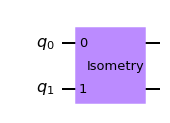

In [14]:
qc.draw('mpl')

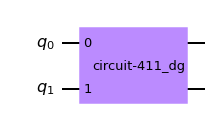

In [15]:
qc.decompose().draw('mpl')

In [16]:
# Initialise the HHL algorithm
hhl = HHL()

In [17]:
# We solve the algorithm
solution = hhl.solve(matrix, qc, observable)


In [18]:
# Observable
solution.observable

0.9115476377217351

***
What this means?

***

In [19]:
matrixObservable = TridiagonalToeplitz(2, 1, 1 / 2)
matrixObservable.matrix

array([[1. , 0.5, 0. , 0. ],
       [0.5, 1. , 0.5, 0. ],
       [0. , 0.5, 1. , 0.5],
       [0. , 0. , 0.5, 1. ]])

In [20]:
np.matmul(classical_solution.state,np.matmul(matrixObservable.matrix,classical_solution.state))

0.931634446397188

***
We get very close solution!

Let us use different observable!
***

In [21]:
observable2 = MatrixFunctional(1, 0)
solution2 = hhl.solve(matrix, qc, observable2)

solution2.observable

3.9446886364773524

In [22]:
np.dot(classical_solution.state,classical_solution.state)

3.9727592267135314

***
Again, very good agreement!
***

In [23]:
print(solution.state)

       ┌──────────────┐┌──────┐        ┌─────────┐
q12_0: ┤0             ├┤4     ├────────┤4        ├
       │  circuit-410 ││      │        │         │
q12_1: ┤1             ├┤5     ├────────┤5        ├
       └──────────────┘│      │┌──────┐│         │
q13_0: ────────────────┤0     ├┤3     ├┤0        ├
                       │      ││      ││         │
q13_1: ────────────────┤1 QPE ├┤2     ├┤1 QPE_dg ├
                       │      ││      ││         │
q13_2: ────────────────┤2     ├┤1     ├┤2        ├
                       │      ││  1/x ││         │
q13_3: ────────────────┤3     ├┤0     ├┤3        ├
                       │      ││      ││         │
   a1: ────────────────┤6     ├┤      ├┤6        ├
                       └──────┘│      │└─────────┘
  q14: ────────────────────────┤4     ├───────────
                               └──────┘           


***

* Classical solution .state returned the solution

* Quantum solution .state returns quantum circuit which prepared the solution!


***

In [24]:
from qiskit.quantum_info import Statevector

stateVector = Statevector(solution.state).data

print(stateVector)

[ 7.73345785e-02+7.75407312e-02j -9.41115742e-02-9.39004268e-02j
  5.97600595e-03+5.77984263e-03j  2.39311393e-01+2.39110235e-01j
  4.14341348e-03-4.28318088e-03j -4.49792446e-03+4.40583627e-03j
 -3.55382787e-03+3.63661939e-03j  5.74971867e-03-5.61781129e-03j
  2.69214170e-03-3.33512771e-03j -4.52031446e-03+4.15003229e-03j
 -1.54405625e-03+1.92731032e-03j  7.69927936e-03-7.04671269e-03j
 -1.73972990e-03-2.22797252e-03j -7.72504249e-04-1.03857477e-03j
  1.01532281e-04+3.79455482e-04j -5.27232770e-04-3.12701810e-05j
  2.35005280e-02-2.34762729e-02j -1.29377006e-02+1.29449134e-02j
 -1.42118517e-02+1.42108766e-02j  2.27586152e-02-2.27835994e-02j
  8.67182459e-03+8.69715938e-03j -4.68959071e-03-4.67067295e-03j
 -6.23042018e-03-6.25027849e-03j  6.17289167e-03+6.14757437e-03j
  1.30984295e-02+1.32480844e-02j -6.62956040e-03-6.55033449e-03j
 -8.75197846e-03-8.87830098e-03j  9.75571079e-03+9.57729785e-03j
  8.59819531e-05-2.08723131e-04j -1.74379493e-04+1.12979676e-04j
  1.11141548e-03-9.992045

***
Extracting the solution for exact 2x2 case:

***

In [25]:
matrixSmall = TridiagonalToeplitz(1, 1, -1 / 3)
vector = np.array([1, 0])


In [26]:
matrixSmall.matrix

array([[ 1.        , -0.33333333],
       [-0.33333333,  1.        ]])

In [27]:
solutionSmall = HHL().solve(matrixSmall, vector)

In [28]:
stateVector = Statevector(solutionSmall.state).data

# Extract the right vector components. 

print(stateVector)

[ 4.33012702e-01-4.56921438e-17j -4.33012702e-01-5.79891570e-16j
 -6.81286880e-17+1.21130180e-16j  9.19392076e-17+1.46276192e-16j
 -2.84034821e-16+3.18005055e-16j  1.53964102e-16+4.56921438e-17j
  1.50274614e-16-8.43311379e-17j  2.68031548e-16+4.56921438e-17j
 -2.25835328e-16+6.47049822e-17j -3.17703567e-17+6.25277055e-16j
  3.30974725e-16+6.47049822e-17j -2.27588711e-16+1.68662276e-17j
  2.03693583e-16+4.44655091e-17j -2.92215546e-16-4.20122396e-17j
  4.80791253e-17+4.44655091e-17j -5.54410596e-18-2.23860839e-17j
  7.50000000e-01-9.01576529e-17j  2.50000000e-01+3.74736911e-16j
  2.13973408e-16-4.92493845e-16j -2.98012594e-16+2.39193773e-17j
 -5.74836793e-17-7.18501295e-16j -1.69203376e-16-2.69246324e-16j
  3.02521756e-16+2.13741102e-16j  2.81620466e-16+5.21319762e-17j
 -1.30181712e-16-4.31162109e-16j -7.58235538e-17-1.80928623e-16j
  1.41158930e-16+4.96787067e-17j  8.03327159e-17+3.06658683e-18j
  5.31300993e-17+4.01722875e-17j  3.19622425e-16-2.02394731e-17j
  3.48987315e-17-4.210423

***
We can find the solution (0.75, 0.25)
***

In [29]:
classSolutionSmall = NumPyLinearSolver().solve(matrixSmall.matrix, vector / np.linalg.norm(vector))

In [30]:
classSolutionSmall.state

array([1.125, 0.375])

***
# Quantum Phase Estimation

The Quantum Phase Estimator is a circuit that estimates the phase of a unitary operator $U$.

The problem solved is as follows:

$$
U|\Psi>=e^{2\pi i \theta}|Psi>\,,
$$

where $|\Psi>$ is an eigenvector and $e^{2\pi i \theta}$ is the corresponding eigenvalue.

We build the QPE on the example:

We consider $T$-gate:

$$
T|1>= e^{i\frac{\pi}{4}}|1>= e^{i 2 \pi\frac{1}{4}}|1>
$$

The expression for $\Theta$ gives:

$$
\Theta=\frac{1}{8}
$$





***

In [31]:
# We need to define n-qubits for counting register
# Plus one qubit to store |Psi>, this will be initialised as |1> as T|1>=exp(i pi /4)|1>

nQubits = 3


# We do not need to do measurement on state with |Psi>
qpe = QuantumCircuit(nQubits+1, nQubits)


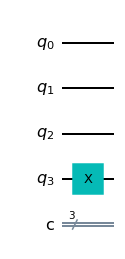

In [32]:
# First, we initialise the |Psi> as |1>
qpe.x(nQubits)
qpe.draw('mpl')

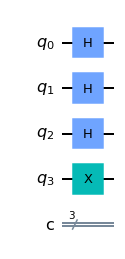

In [33]:
# We need to apply Hadamard gates on the counting qubits
for i in range(nQubits):
    qpe.h(i)
qpe.draw('mpl')

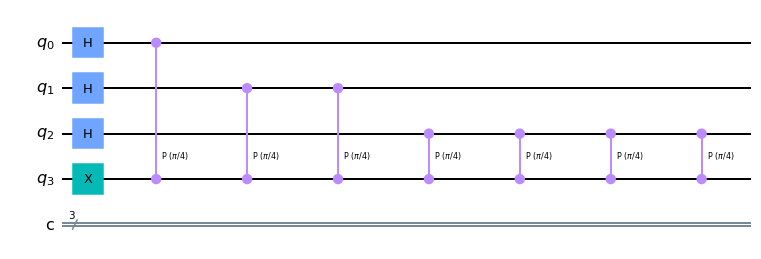

In [34]:
# We apply controlled unitary operation with pi/4 angle
# The first counting qubit, we apply it 2^0
# The second counting qubit, we apply it 2^1
# The third counting qubit, we apply it 2^2
# ...

import math as math

for i in range(nQubits):
    for j in range(2**i):
        qpe.cp(math.pi/4, i, nQubits)

qpe.draw('mpl')

In [35]:
# We need inverse Fourier transform
# We use the Qiskit function provided
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

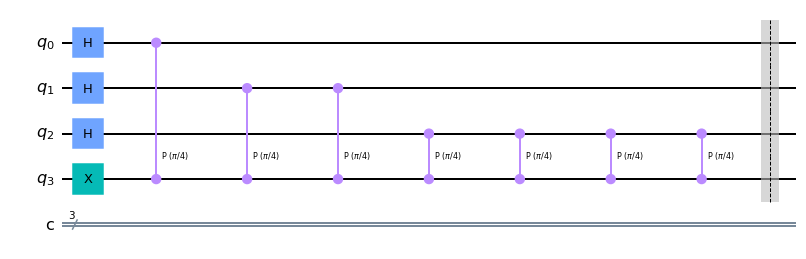

In [36]:
# We add barier (for visual considerations):
qpe.barrier()
qpe.draw('mpl')

In [37]:
# Inverse Quantum Fourier Transform
qft_dagger(qpe, nQubits)

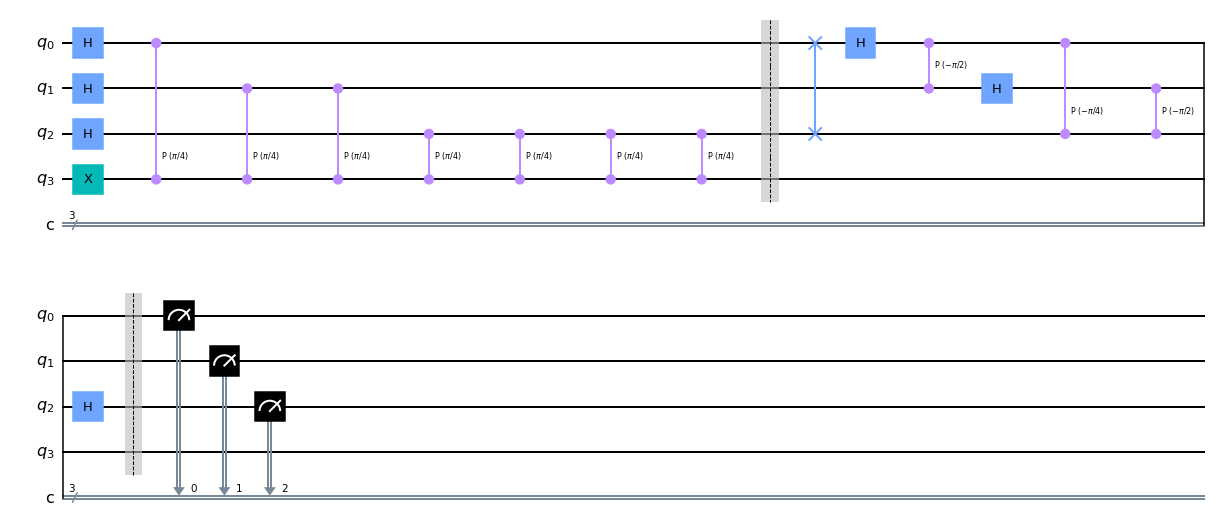

In [38]:
# Add measurement
qpe.barrier()
for i in range(nQubits):
    qpe.measure(i,i)
    
qpe.draw('mpl')

***
We have circuit, so we can perform measurement:

***

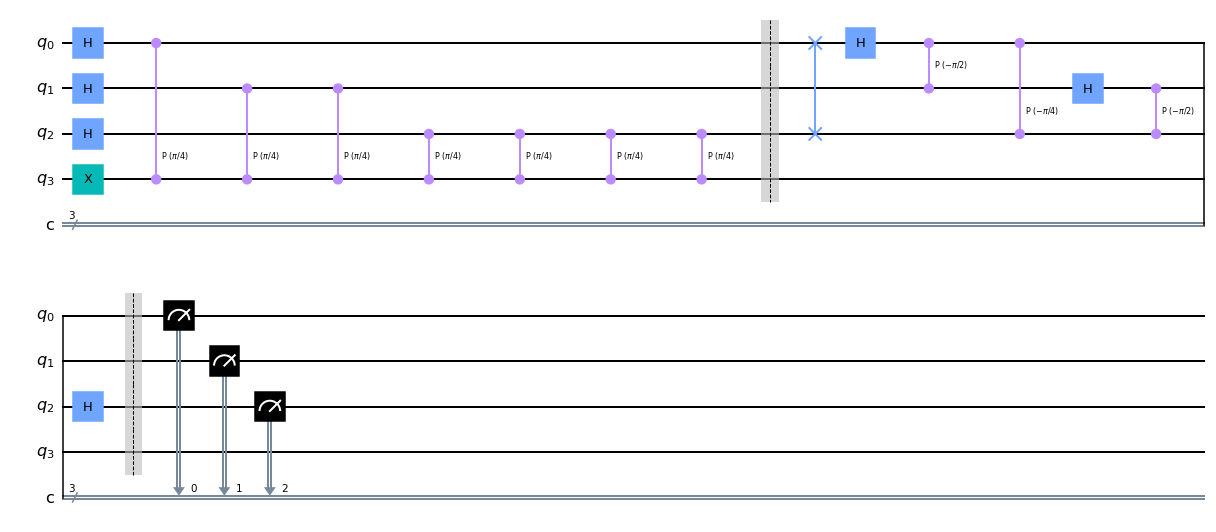

In [39]:
# We transpile the circuit
from qiskit import transpile

tQpe = transpile(qpe, simulator)
tQpe.draw('mpl')

In [40]:
from qiskit import assemble
results = simulator.run(assemble(tQpe, shots=1024)).result()

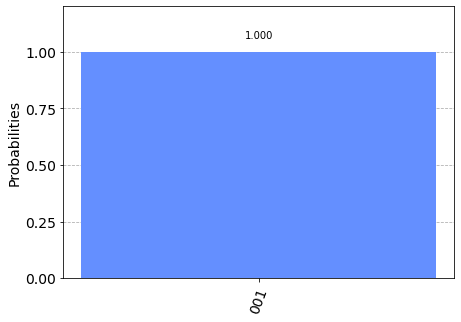

In [41]:
plot_histogram(results.get_counts())

***
$2^{nQubits} \Theta = 1$

which gives us:

$\Theta=\frac{1}{8}$

As expected!

We can try this with different number of nQubits!

The conversions is:

$$
int('xxxxx', 2)/2^{nQubits}
$$

where 'xxxxx' is register with largest number of counts, base=2.

***

In [42]:
counts = results.get_counts()
counts

{'001': 1024}

***
## Pi Estimation

Qiskit example.

We use QPE to estimate $\pi$ (using the nice qiskit example).

The problem is as follows:

$$
p(\Theta)|1>=e^{i\Theta}|1>\,.
$$

If we choose $\Theta=1$, we can get estimate of $\pi$. We use the qiskit code for this estimation:

***

In [43]:
# pi
pi = np.pi

from qiskit.tools.monitor import job_monitor

# we wrap the circuit preparation to a function
def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

# running the circuit
def run_job(circ, backend, shots=1024, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

# Pi estimator
def get_pi_estimate(n_qubits):

    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    # create the input state
    qpe_pre(circ, n_qubits)
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))

    # run the job and get the results
    counts = run_job(circ, backend=simulator, shots=10000, optimization_level=0)
    # print(counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

# We run estimations
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job has successfully run
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
5 qubits, pi ≈ 3.2
Job Status: job has successfully run
6 qubits, pi ≈ 3.2
Job Status: job has successfully run
7 qubits, pi ≈ 3.2
Job Status: job has successfully run
8 qubits, pi ≈ 3.1219512195121952
Job Status: job has successfully run
9 qubits, pi ≈ 3.1604938271604937
Job Status: job has successfully run
10 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
11 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
12 qubits, pi ≈ 3.1411042944785277


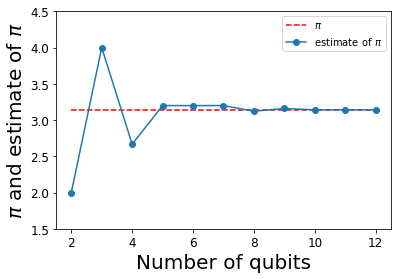

In [44]:
import matplotlib.pyplot as plotter

plotter.plot(nqs, [pi]*len(nqs), '--r')
plotter.plot(nqs, pi_estimates, '.-', markersize=12)
plotter.xlim([1.5, 12.5])
plotter.ylim([1.5, 4.5])
plotter.legend(['$\pi$', 'estimate of $\pi$'])
plotter.xlabel('Number of qubits', fontdict={'size':20})
plotter.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plotter.tick_params(axis='x', labelsize=12)
plotter.tick_params(axis='y', labelsize=12)
plotter.show()